In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.stats import linregress as linreg

import scipy.fftpack as fft


from scipy.io import loadmat
from pytex import *
from math import factorial
from fractions import Fraction as frac

In [2]:
matplotlib.rcParams.update({'font.size': 16})

# 1

In [31]:
part = 'f'

# whole integers must be used to accurately calculate the 
# fractional coefficient

if part is 'a':
    alphas_num = [2, -1, -1]
    betas_num  = [0, 2, 0]
    amult, adiv = 1, 2
    bmult, bdiv = 1, 1
    
elif part is 'b':
    alphas_num = [1, -1]
    betas_num  = [0, 0]
    amult, adiv = 1, 1
    bmult, bdiv = 1, 1
    
elif part is 'c':
    alphas_num = [1, 0, 0, 0, -1]
    betas_num  = [0, 1, 1, 1, 0]
    amult, adiv = 1, 1
    bmult, bdiv = 4, 3
    
elif part is 'd':
    alphas_num = [1, 0, -1, 0]
    betas_num  = [0, 7, -2, 1]
    amult, adiv = 1, 1
    bmult, bdiv = 1, 3
    
elif part is 'e':
    alphas_num = [19, -8, 0, 8, 0]
    betas_num  = [1, 4, 0, 4, 1]
    amult, adiv = 1, 19
    bmult, bdiv = 6, 19
    
elif part is 'f':
    alphas_num = [1, 1, -1, -1]
    betas_num  = [0, 1, 1, 0]
    amult, adiv = 1, 1
    bmult, bdiv = 2, 1
    


alphas_num = alphas_num[::-1]
betas_num = betas_num[::-1]
alphas = [amult/adiv*a for a in alphas_num]
betas = [bmult/bdiv*b for b in betas_num]

coeffs = []

for q in range(1,1000):
    print('Term: %d' %q)
    terms = [1/factorial(q)*j**q * a - 1/factorial(q-1)*j**(q-1) * b for j, (a,b) in enumerate(zip(alphas, betas))]
    coeffs += [sum(terms)]
    print( round(coeffs[-1],4))
    if round(coeffs[-1],10) != 0:
        print('\n')
        break
        
print('Accuracy: %d' % (q-1))
terms = []
for j, (a,b) in enumerate(zip(alphas_num, betas_num)):
    terms += [frac(j**q * a*amult, factorial(q)*adiv) - frac(j**(q-1) * b*bmult, factorial(q-1)*bdiv)]
print('Coeff: ', sum(terms), 'k^%d'%q)

Term: 1
0.0
Term: 2
0.0
Term: 3
0.6667


Accuracy: 2
Coeff:  2/3 k^3


# 2

In [3]:
def rk4(f, a, b, y0, N):
    if np.ndim(y0) is 0:
        ys = np.zeros(N+1)
    else:
        ys = np.zeros((N+1,len(y0)))
    
    k = (b - a)/N
    ys[0] = y0
    ts = np.linspace(a,b,N+1)
    
    for i in range(N):
        t = ts[i]
        y1 = ys[i]
        f1 = f(t,y1)
        y2 = y1 + k/2*f1
        f2 = f(t+k/2, y2)
        y3 = y1 + k/2*f2
        f3 = f(t+k/2, y3)
        y4 = y1 + k*f3
        ys[i+1] = y1 + k/6*( f1 + 2*f2 + 2*f3 + f(t+k, y4) )
    
    return ts, ys

def abm4(f, a, b, y0, N):
    if np.ndim(y0) is 0:
        ys = np.zeros(N+1)
    else:
        ys = np.zeros((N+1,len(y0)))
    
    k = (b - a)/N
    ys[0] = y0
    ts = np.linspace(a,b,N+1)
    
    temp, ys[:4] = rk4(f, a, a+3*k, y0, 3)
    fs = np.zeros(ys.shape)
    fs[0] = f(ts[0], ys[0])
    fs[1] = f(ts[1], ys[1])
    fs[2] = f(ts[2], ys[2])
    
    for i in range(3, N):
        fs[i] = f(ts[i], ys[i])
        y_star = ys[i] + k/24*( 55*fs[i] - 59*fs[i-1] + 37*fs[i-2] - 9*fs[i-3] )
        ys[i+1] = ys[i] + k/24*( 9*f(ts[i+1],y_star) + 19*fs[i] - 5*fs[i-1] + fs[i-2] )
    
    return ts, ys

In [4]:

def forcing(t, y):
    return 1 + y/t + (y/t)**2
def exact(t):
    return t*np.tan(np.log(t))
a, b = 1, 3
y0 = 0

'''
# This problem tests that the code words for vectors
def forcing(t, y):
    u, v = y
    return np.array([v/3, v*(v-1)/(3*u)])
def exact(t):
    temp = 3*np.exp(-8/3*t)
    ret = np.zeros((len(t), 2))
    ret[:,0] = (1+temp)/8
    ret[:,1] = -temp
    return ret
a, b = 0, 1
y0 = np.array([.5, -3])
'''


Ns = [50*2**i for i in range(8)]

ks = [(b - a)/N for N in Ns]
errors_rk4 = []
errors_abm4 = []

for N in Ns:
    ts, ys = rk4(forcing, a, b, y0, N)
    y_true = exact(ts)
    error = la.norm(ys[-1] - y_true[-1])/la.norm(y_true[-1])
    errors_rk4.append(error)
    
    ts, ys = abm4(forcing, a, b, y0, N)
    y_true = exact(ts)
    error = la.norm(ys[-1] - y_true[-1])/la.norm(y_true[-1])
    errors_abm4.append(error)


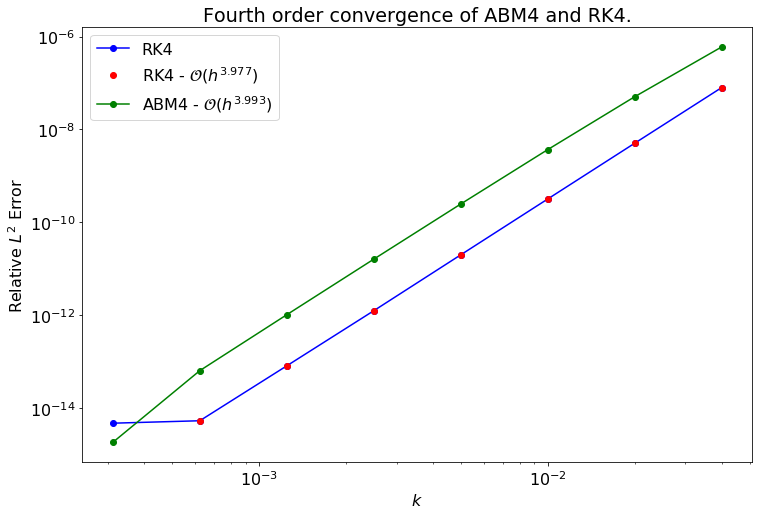

In [5]:
RK4_order = linreg(np.log(ks[:-1]), np.log(errors_rk4[:-1]))[0]
ABM4_order = linreg(np.log(ks), np.log(errors_abm4))[0]


plt.figure(figsize=(12,8))
#plt.plot(ts, exact(np.array(ts)), 'b-')
#plt.plot(ts, ys, 'r--')

plt.loglog(ks, errors_rk4,'b-o', label='RK4')
plt.loglog(ks[:-1], errors_rk4[:-1],'ro', label=('RK4 - $\mathcal{O}(h^{%.3f})$'%RK4_order))
plt.loglog(ks, errors_abm4,'g-o', label=('ABM4 - $\mathcal{O}(h^{%.3f})$'%ABM4_order))
plt.legend()
plt.xlabel('$k$')
plt.ylabel('Relative $L^2$ Error')

plt.title('Fourth order convergence of ABM4 and RK4.')
plt.show()

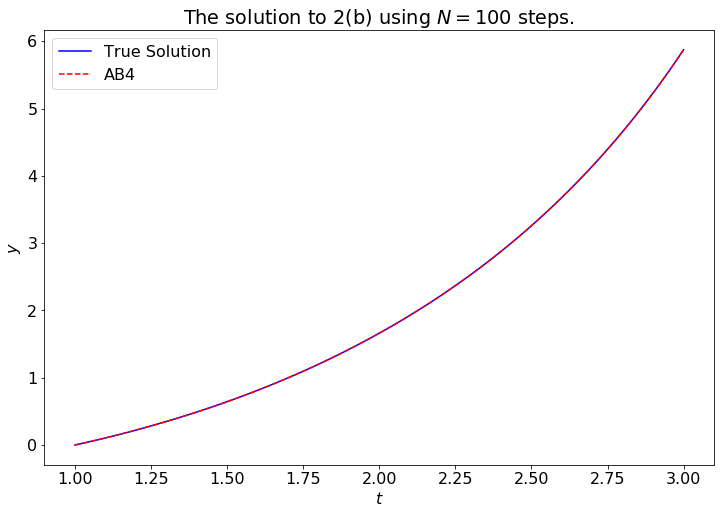

In [6]:
ts, ys = rk4(forcing, a, b, y0, 100)
y_true = exact(ts)

plt.figure(figsize=(12,8))
plt.plot(ts, y_true, 'b-', label='True Solution')
plt.plot(ts, ys, 'r--', label='AB4')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.title("The solution to 2(b) using $N=100$ steps.")
plt.legend()
plt.show()

In [7]:
Ns

[50, 100, 200, 400, 800, 1600, 3200, 6400]

# 3

\begin{equation*}
\begin{array}{rll}
x_1''(t) = x_1(t) + 2x_2'(t) - \mu^{*}\dfrac{x_1 + \mu}{D_1} - \mu\dfrac{x_1 - \mu^{*}}{D_2}, & x_1(0) = 0.994,\;x_1'(0) = 0,\\
\\
x_2''(t) = x_2(t) - 2x_1'(t) - \mu^{*}\dfrac{x_2}{D_1} - \mu\dfrac{x_2}{D_2}, & x_2(0) = 0,\;x_2'(0) = -2.0015851063790825,\\
\end{array}
\end{equation*}
where,
\begin{equation*}
\begin{array}{c}
0 \leq t \leq b=17.06521656015796, \\
\mu = 0.012277471,\;\; \mu^{*} = 1-\mu, \\
D_1 = ((x_1 + \mu)^2 + x_2^2)^{3/2}, \;\; D_2 = ((x_1 - \mu^{*})^2 + x_2^2)^{3/2}, \\
\end{array}
\end{equation*}

First order system of ODES

Let 
\begin{align*}
y_0 &= x_1 \\
y_1 &= x'_1 \\
y_2 &= x_2 \\
y_3 &= x'_2
\end{align*}

Which gives
\begin{equation*}
\begin{array}{rll}
y_0' &= y_1, & y_0(0) = 0.994, \\
y_1' &= y_0 + 2y_3 - \mu^{*}\dfrac{y_0 + \mu}{D_1} - \mu\dfrac{y_0 - \mu^{*}}{D_2}, & y_1(0) = 0,\\
y_2' &= y_3, & y_2(0) = 0, \\
y_3' &= y_2 - 2y_1 - \mu^{*}\dfrac{y_2}{D_1} - \mu\dfrac{y_2}{D_2}, & y_3(0) = -2.0015851063790825
\end{array}
\end{equation*}
where,
\begin{equation*}
\begin{array}{c}
0 \leq t \leq b=17.06521656015796, \\
\mu = 0.012277471,\;\; \mu^{*} = 1-\mu, \\
D_1 = ((y_0 + \mu)^2 + y_2^2)^{3/2}, \;\; D_2 = ((y_0 - \mu^{*})^2 + y_2^2)^{3/2}, \\
\end{array}
\end{equation*}

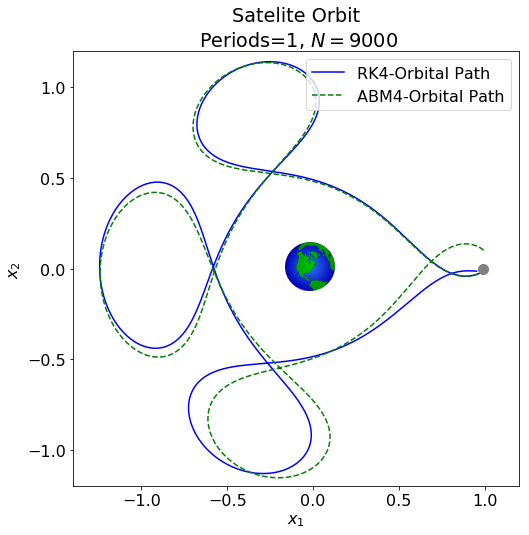

In [25]:
mu = 0.012277471
#mu = .9
mu_star = 1-mu
def forcing(t, y):
    y0, y1, y2, y3 = y
    D1 = ( (y0+mu)**2 + y2**2 )**(3/2)
    D2 = ( (y0-mu_star)**2 + y2**2 )**(3/2)
    return np.array([y1, 
                     y0 + 2*y3 - mu_star*(y0+mu)/D1 - mu*(y0-mu_star)/D2,
                     y3,
                     y2 - 2*y1 - mu_star*y2/D1 - mu*y2/D2])


N = 9000 #1 * 10**3
periods = 1
not_fixed = True

a, b = 0, 17.06521656015796*periods
if not_fixed:
    y0 = np.array([0.994, 0, 0, -2.0015851063790825])
else:
    y0 = np.array([1.2, 0, 0, -2.0015851063790825])

earth_size = 5
moon_size = 10

fig = plt.figure(figsize=(8,8))
ts, ys = rk4(forcing, a, b, y0, N)
plt.plot(ys[:,0], ys[:,2], 'b-', label='RK4-Orbital Path')
ts, ys = abm4(forcing, a, b, y0, N)
plt.plot(ys[:,0], ys[:,2], 'g--', label='ABM4-Orbital Path')
# plot earth
#plt.plot([-mu], [0], 'bo', markersize=earth_size, label='Earth')
#plt.plot([-mu], [0], 'g*', markersize=earth_size)
#plt.text(.05, -.1, 'Earth')
#plot moon
#plt.plot([mu_star], [0], 'o', markersize=moon_size, color='gray', label='Moon')
plt.plot([mu_star], [0], 'o', markersize=moon_size, color='gray')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.text(1-.05, -.05, 'Moon')

if not_fixed:
    plt.title("Satelite Orbit\n Periods=%d, $N=%d$" % (periods, N))
else:
    plt.title('Satelite-2 Trajectory\n "Periods"=%d, $N=%d$' % (periods, N))
plt.legend(loc=1)

plt.xlim((-1.4, 1.2))
plt.ylim((-1.2, 1.2))

earth = plt.imread('small_earth.png')
earth_loc = plt.gca().transData.transform((-mu,0))
earth_offset = (25,45)
fig.figimage(earth, xo=earth_loc[0]-earth_offset[0], yo=earth_loc[1]-earth_offset[1], zorder=1)

plt.show()

# 4

In [24]:
from sympy import *
init_printing()

In [27]:
t = symbols('t')

In [28]:
for j in range(2, -1, -1):
    L = 1
    for i in range(3):
        if i != j:
            L *= (t-i)/(j-i)
    I = integrate(L, (t, 1, 3))
    display(I)

In [26]:
x = symbols('x')

In [57]:
((x - (2+8j))*(x - (2-8j))).expand()

# 4(b)

In [4]:
#def xi_LLM(w):
#    return 3*(w**3 - w)/(7*w**2 - 2*w + 1)
#def sig_LLM(w):
#    return (7*w**2 - 2*w + 1)
#def xi_LLM(w):
#    return rho_LLM(w)/sig_LLM(w)

rho_LLM = np.polynomial.Polynomial([0,-1,0,1])
sig_LLM = np.polynomial.Polynomial([1,-2,7])/3
xi_LLM = lambda w: rho_LLM(w)/sig_LLM(w)

'''
rho_LLM = np.polynomial.Polynomial([0,-1,1])
sig_LLM = np.polynomial.Polynomial([-1,3])/2
xi_LLM = lambda w: rho_LLM(w)/sig_LLM(w)
'''

#def xi_AB3(w):
#    return 12*(w**3 - w**2)/(23*w**2 - 16*w + 5)

rho_AB3 = np.polynomial.Polynomial([0,0,-1,1])
sig_AB3 = np.polynomial.Polynomial([5,-16,23])/12
xi_AB3 = lambda w: rho_AB3(w)/sig_AB3(w)

-1.0
1.0
0.0


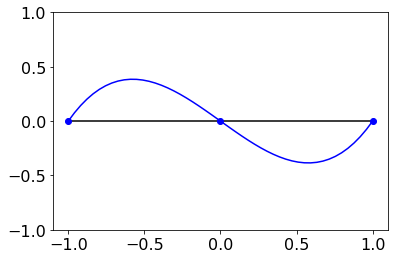

In [5]:
my_poly = rho_LLM 

xs = np.linspace(-1,1)
roots = np.roots( (my_poly).coef[::-1] )
for r in roots: print(r)
roots = roots[np.abs(np.imag(roots))<10**-10]

plt.plot(xs, [0]*len(xs), 'k-')
plt.plot(xs, my_poly(xs), 'b-')
plt.plot(roots, [0]*len(roots), 'bo')
plt.ylim(-1,1)
plt.show()

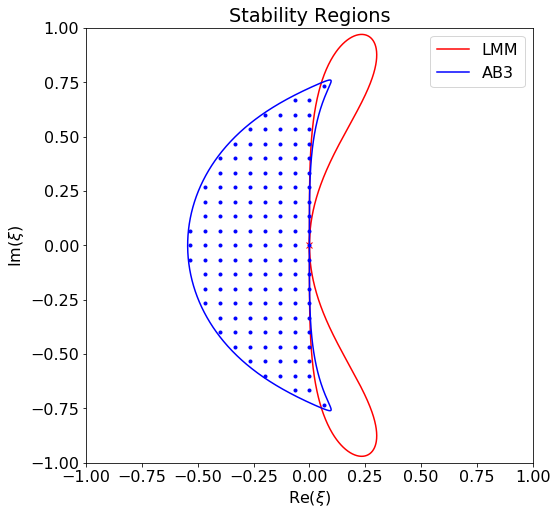

In [6]:
plot_outer = False
'''
setting equal to 1 is the true A-Stable region. 
Allowing for 1 large eval gives the actual 
stability region for some reason.
'''
ts = np.linspace(0, 2*np.pi, 1000)
ws = np.exp(ts*1j)
zs_LLM = xi_LLM(ws)
zs_AB3 = xi_AB3(ws)

#Test Points
lin = np.linspace(-1,1,31)
X, Y = np.meshgrid(lin,lin)
Zs = (X + Y*1j).flatten()

plt.figure(figsize=(8,8))
plt.plot(np.real(zs_LLM), np.imag(zs_LLM), 'r-', label='LMM')
plt.plot(np.real(zs_AB3), np.imag(zs_AB3), 'b-', label='AB3')

for xi in Zs:
    roots = np.roots( (rho_LLM - xi*sig_LLM).coef[::-1] )
    # stable if all |xi| <=1
    # and no double roots where |xi|=1
    none_large = np.all(np.abs(roots)<=1)
    if plot_outer:
        none_large = np.sum(np.abs(roots)<=1)>1
    double_roots = np.sum(roots[np.abs(roots)==1])>1
    if none_large and not double_roots:
        plt.plot(np.real(xi),np.imag(xi),'rx')
    
    roots = np.roots( (rho_AB3 - xi*sig_AB3).coef[::-1] )
    none_large = np.all(np.abs(roots)<=1)
    double_roots = np.sum(roots[np.abs(roots)==1])>1
    if none_large and not double_roots:
        plt.plot(np.real(xi),np.imag(xi),'b.')
        
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.title('Stability Regions')
plt.xlabel('Re($\\xi$)')
plt.ylabel('Im($\\xi$)')

plt.show()

In [197]:
xi = .2+.8j
#xi = -.5
roots = np.roots( (rho_LLM - xi*sig_LLM).coef[::-1] )
for r in roots: print(r)

(-0.30820656392563767+1.1296673609826915j)
(0.743084102162998+0.9314280746661735j)
(0.0317891284293063-0.19442876898219788j)


In [128]:
# Nowhere Stable!?

def my_llm(f, a, b, y0, N):
    if np.ndim(y0) is 0:
        ys = np.zeros(N+1)
    else:
        ys = np.zeros((N+1,len(y0)))
    
    k = (b - a)/N
    ys[0] = y0
    ts = np.linspace(a,b,N+1)
    
    temp, ys[:4] = rk4(f, a, a+3*k, y0, 3)
    fs = np.zeros(ys.shape)
    fs[0] = f(ts[0], ys[0])
    fs[1] = f(ts[1], ys[1])
    fs[2] = f(ts[2], ys[2])
    
    for i in range(3, N):
        fs[i] = f(ts[i], ys[i])
        ys[i+1] = ys[i-1] + k/3*( 7*fs[i] - 2*fs[i-1] + fs[i-2] )
    return ts, ys

def forward_euler(A, a, b, y0, N):
    if np.ndim(y0) is 0:
        ys = np.zeros(N+1)
    else:
        ys = np.zeros((N+1,len(y0)))
    
    k = (b - a)/N
    ys[0] = y0
    ts = np.linspace(a,b,N+1)
    #fs = np.zeros(ys.shape)
    M = np.eye(2) + k*A
    for i in range(0, N):
        #fs[i] = f(ts[i], ys[i])
        ys[i+1] = M @ ys[i]
    return ts, ys

def back_euler(A, a, b, y0, N):
    if np.ndim(y0) is 0:
        ys = np.zeros(N+1)
    else:
        ys = np.zeros((N+1,len(y0)))
    
    k = (b - a)/N
    ys[0] = y0
    ts = np.linspace(a,b,N+1)
    M = np.eye(2) - k*A
    #fs = np.zeros(ys.shape)
    for i in range(0, N):
        #fs[i] = f(ts[i], ys[i])
        ys[i+1] = la.solve(M, ys[i])
    return ts, ys

The equation $y'' = -16y' + 68y$ has an eigenvalue of $\lambda = 8+2i$ which can be scaled into the region of instability.

That translates to the system
\begin{align*}
    y_0' &= y_1 \\
    y_1' &= 16y_1 - 68y_0
\end{align*}

In [193]:
stable = False

if not stable:
    problem_tex = "$y'' = 16y' - 68y$"
    A = np.array([[0, 1],[-68,4]])
    def forcing(t, y):
        y0, y1 = y
        return A @ y #np.array([y1, 4*y1-68*y0])
    def exact(t):
        return np.exp(2*t)*np.sin(8*t)
    a, b = 0, 10
    y0 = np.array([0, 8])
    
else:
    problem_tex = "$y' = -y$"
    def forcing(t, y):
        return -y
    def exact(t):
        return np.exp(-t)
    a, b = 0, .5
    y0 = 1



Ns = [10*2**i for i in range(8)]

ks = [(b - a)/N for N in Ns]
errors_rk4 = []
errors_abm4 = []

for N in Ns:
    ts, ys = rk4(forcing, a, b, y0, N)
    if ys.ndim >1:
        ys = ys[:,0]
    y_true = exact(ts)
    error = la.norm(ys[-1] - y_true[-1])/la.norm(y_true[-1])
    errors_rk4.append(error)
    
    #ts, ys = abm4(forcing, a, b, y0, N)
    ts, ys = my_llm(forcing, a, b, y0, N)
    if ys.ndim >1:
        ys = ys[:,0]
    y_true = exact(ts)
    error = la.norm(ys[-1] - y_true[-1])/la.norm(y_true[-1])
    errors_abm4.append(error)


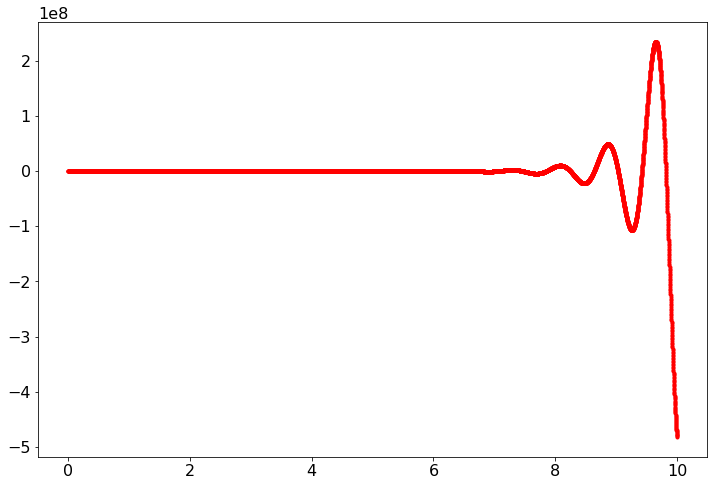

In [194]:
ts, ys = my_llm(forcing, a, b, y0, 10**4)
if ys.ndim >1:
        ys = ys[:,0]

plt.figure(figsize=(12,8))
plt.plot(ts, exact(ts), 'b-')
plt.plot(ts, ys, 'r.')
plt.show()

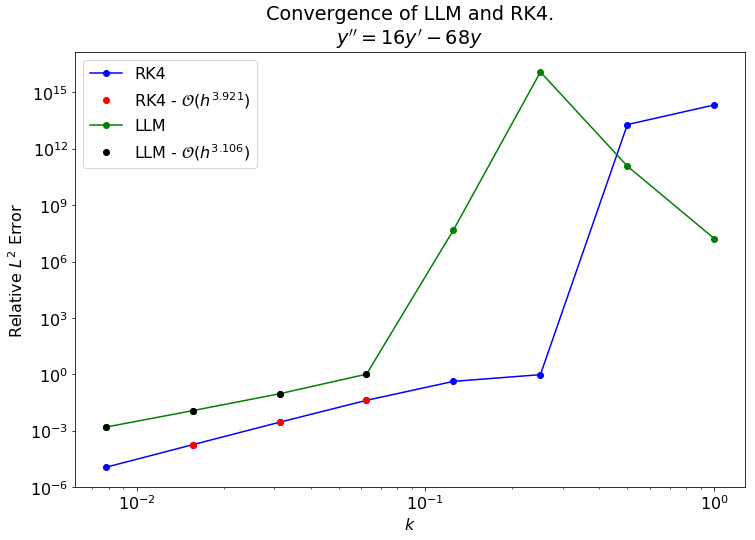

In [195]:

RK4_order = linreg(np.log(ks[4:-1]), np.log(errors_rk4[4:-1]))[0]
LLM_order = linreg(np.log(ks[4:]), np.log(errors_abm4[4:]))[0]


plt.figure(figsize=(12,8))
#plt.plot(ts, exact(np.array(ts)), 'b-')
#plt.plot(ts, ys, 'r--')

plt.loglog(ks, errors_rk4,'b-o', label='RK4')
plt.loglog(ks[4:-1], errors_rk4[4:-1],'ro', label=('RK4 - $\mathcal{O}(h^{%.3f})$'%RK4_order))
plt.loglog(ks, errors_abm4,'g-o', label='LLM')
plt.loglog(ks[4:], errors_abm4[4:],'ko', label=('LLM - $\mathcal{O}(h^{%.3f})$'%LLM_order))
plt.legend()
plt.xlabel('$k$')
plt.ylabel('Relative $L^2$ Error')

plt.title('Convergence of LLM and RK4.\n' + problem_tex)
plt.show()

Want $\lambda = -.8+.2i$

In [196]:
ks